In [1]:
import numpy as np
import pandas as pd
import glob
import json
import random
import os
import tensorflow as tf


# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow

# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms

# Control GPU memory allocation (prevents TensorFlow from using all GPU memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism (ensures consistent execution order)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

import scipy.io 
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report, 
f1_score, precision_score, recall_score, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import signal
from skimage.transform import resize
from sklearn.model_selection import StratifiedKFold
from keras import layers, models, Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, Flatten, MaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model

# Load 2HP CWRU bearing data from .mat files
def import_data():
    """
    Efficiently load CWRU bearing data from .mat files in the specified folder.

    Returns:
        list: A list of NumPy arrays, each corresponding to a different bearing condition.
    """
    folder_path_1 = os.path.join(os.getcwd(), 'CWRU_data', '2HP')

    files = {
        '99.mat': 'X099_DE_time',
        '111.mat': 'X111_DE_time',
        '124.mat': 'X124_DE_time',
        '137.mat': 'X137_DE_time',
        '176.mat': 'X176_DE_time',
        '191.mat': 'X191_DE_time',
        '203.mat': 'X203_DE_time',
        '215.mat': 'X215_DE_time',
        '228.mat': 'X228_DE_time',
        '240.mat': 'X240_DE_time',
    }

    data_2HP = []
    for file_name, key in files.items():
        file_path = os.path.join(folder_path_1, file_name)
        data_2HP.append(scipy.io.loadmat(file_path)[key])

    folder_path_2 =  os.path.join(os.getcwd(), 'CWRU_data', '3HP')
    files = {
        '100.mat': 'X100_DE_time',
        '112.mat': 'X112_DE_time',
        '125.mat': 'X125_DE_time',
        '138.mat': 'X138_DE_time',
        '177.mat': 'X177_DE_time',
        '192.mat': 'X192_DE_time',
        '204.mat': 'X204_DE_time',
        '217.mat': 'X217_DE_time',
        '229.mat': 'X229_DE_time',
        '241.mat': 'X241_DE_time',
    }

    data_3HP = []
    for file_name, key in files.items():
        file_path = os.path.join(folder_path_2, file_name)
        data_3HP.append(scipy.io.loadmat(file_path)[key])

    return data_2HP, data_3HP

data_2HP, data_3HP = import_data()
len(data_2HP), len(data_3HP)


(10, 10)

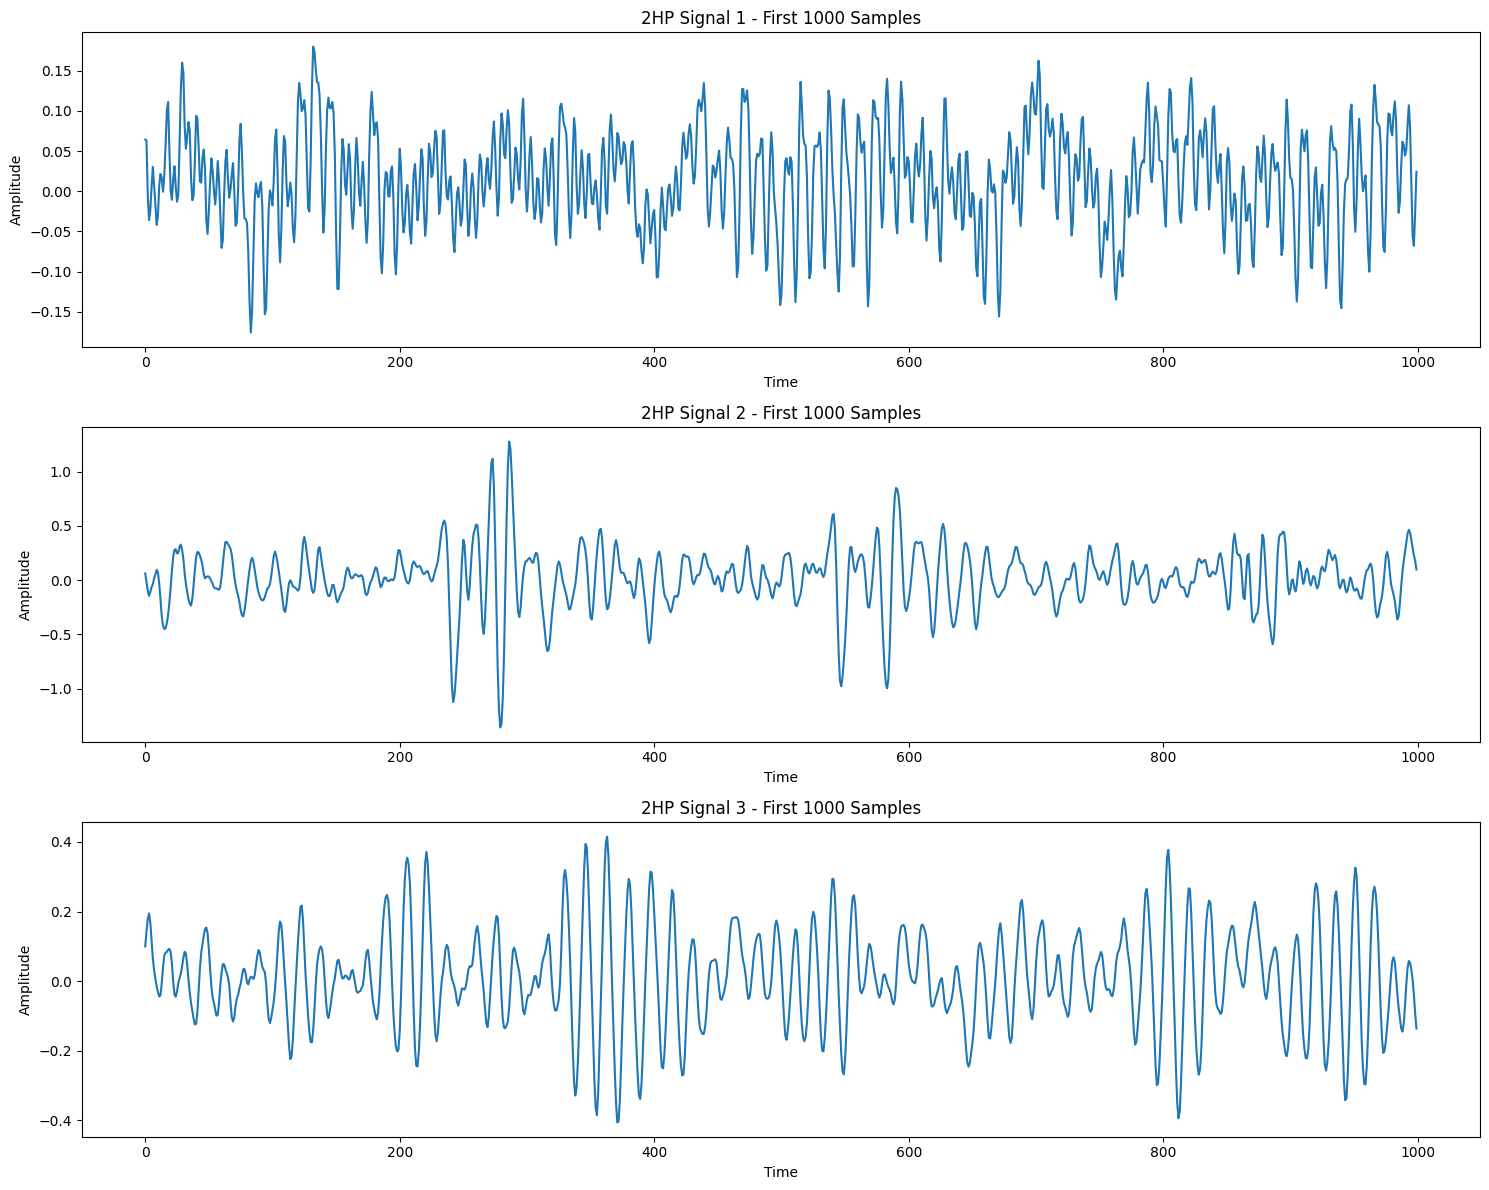

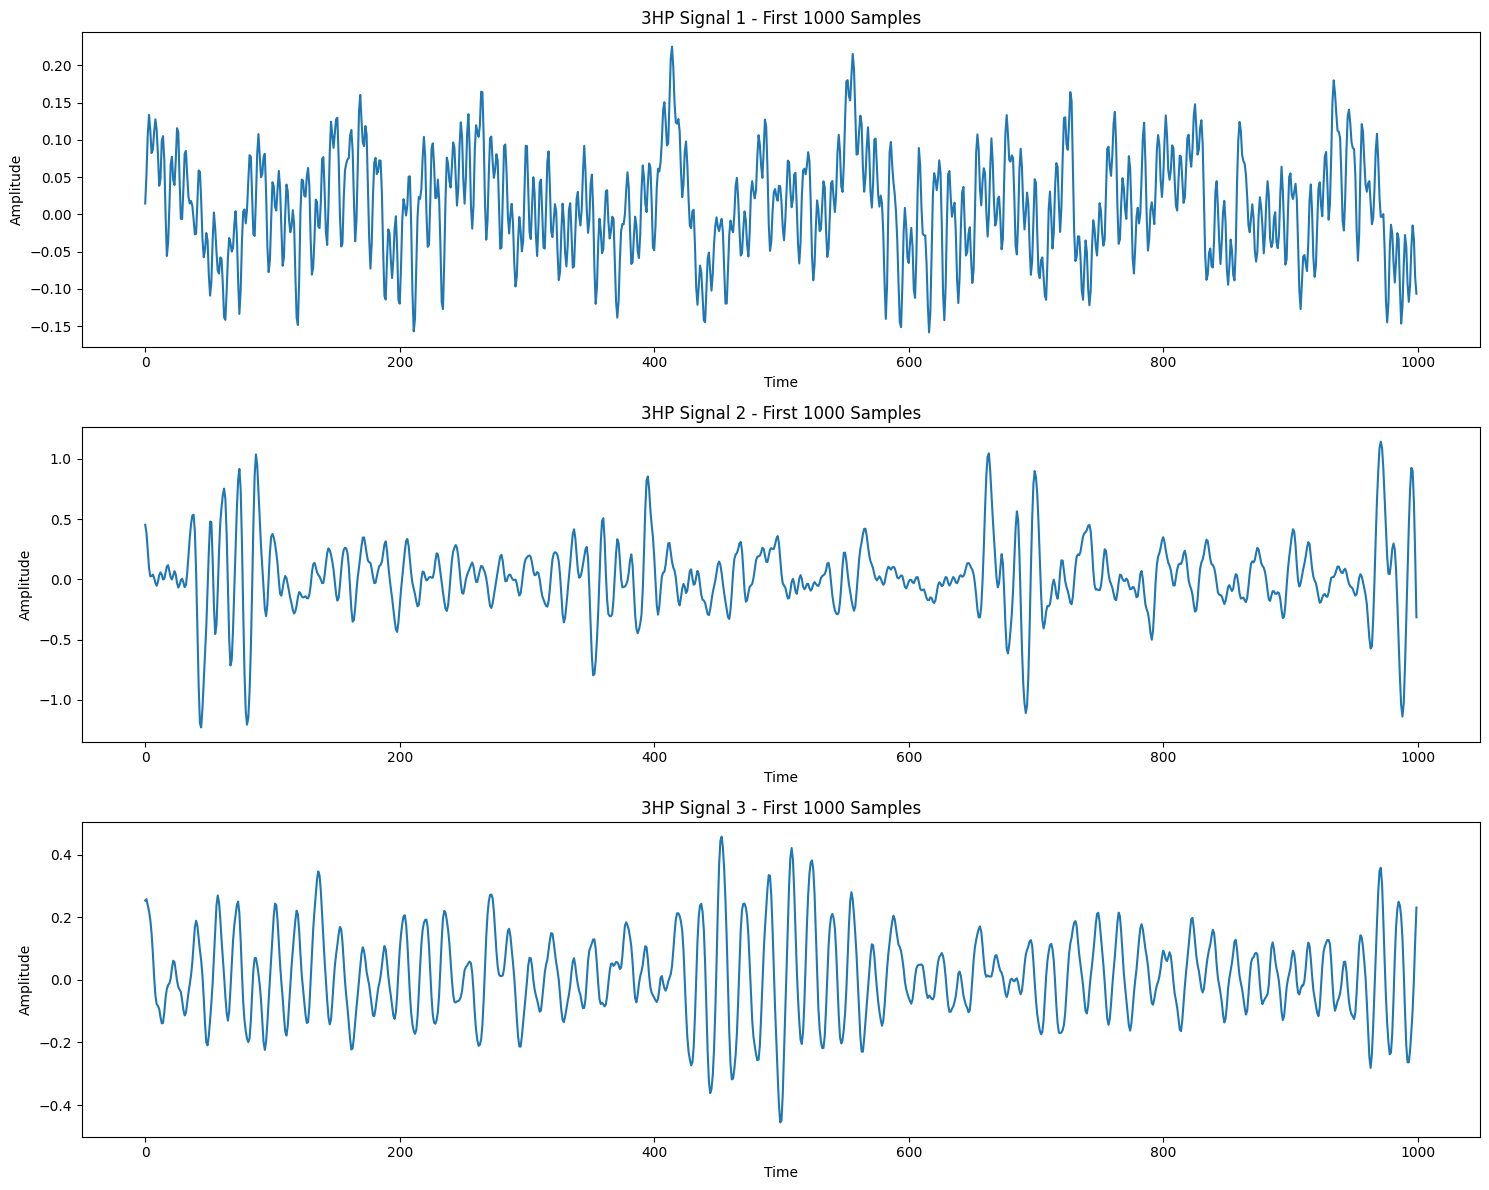

In [3]:
def plot_time_series(data_list, title_prefix, num_signals=3, sample_length=1000):
    """
    Plots the raw time-series data for a few selected signals.

    Args:
        data_list (list): List of numpy arrays of signals.
        title_prefix (str): Title prefix, e.g., '2HP' or '3HP'.
        num_signals (int): Number of signals to plot.
        sample_length (int): Number of points from the signal to display.
    """
    plt.figure(figsize=(15, 4 * num_signals))

    for i in range(num_signals):
        signal = data_list[i].flatten()[:sample_length]
        plt.subplot(num_signals, 1, i+1)
        plt.plot(signal)
        plt.title(f"{title_prefix} Signal {i+1} - First {sample_length} Samples")
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

plot_time_series(data_2HP, title_prefix="2HP", num_signals=3)
plot_time_series(data_3HP, title_prefix="3HP", num_signals=3)


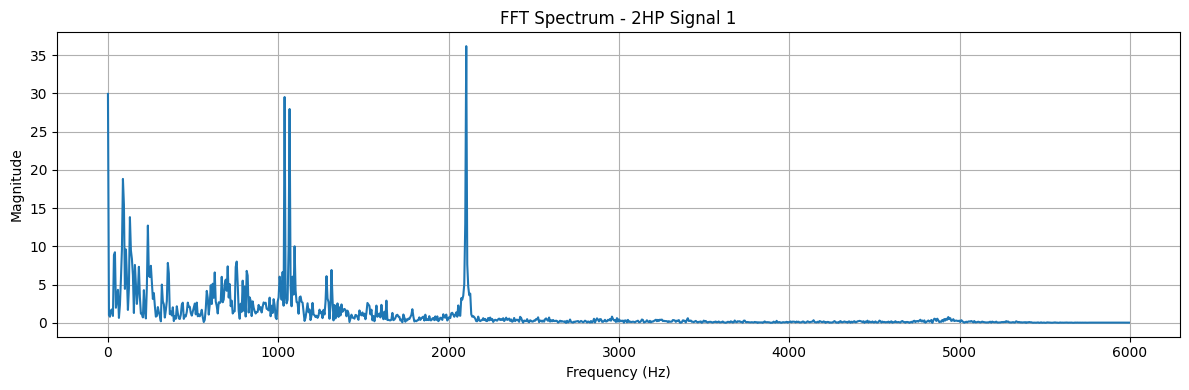

In [4]:
def plot_fft(signal, title, fs=12000):
    """
    Plot FFT of a single signal.

    Args:
        signal (np.array): The raw vibration signal.
        title (str): Title of the plot.
        fs (int): Sampling frequency in Hz (CWRU uses 12kHz).
    """
    N = len(signal)
    fft_vals = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N, 1/fs)

    plt.figure(figsize=(12, 4))
    plt.plot(freqs[:N // 2], np.abs(fft_vals[:N // 2]))
    plt.title(f'FFT Spectrum - {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: Plot FFT of the first 2HP signal
plot_fft(data_2HP[0].flatten()[:2048], title="2HP Signal 1")


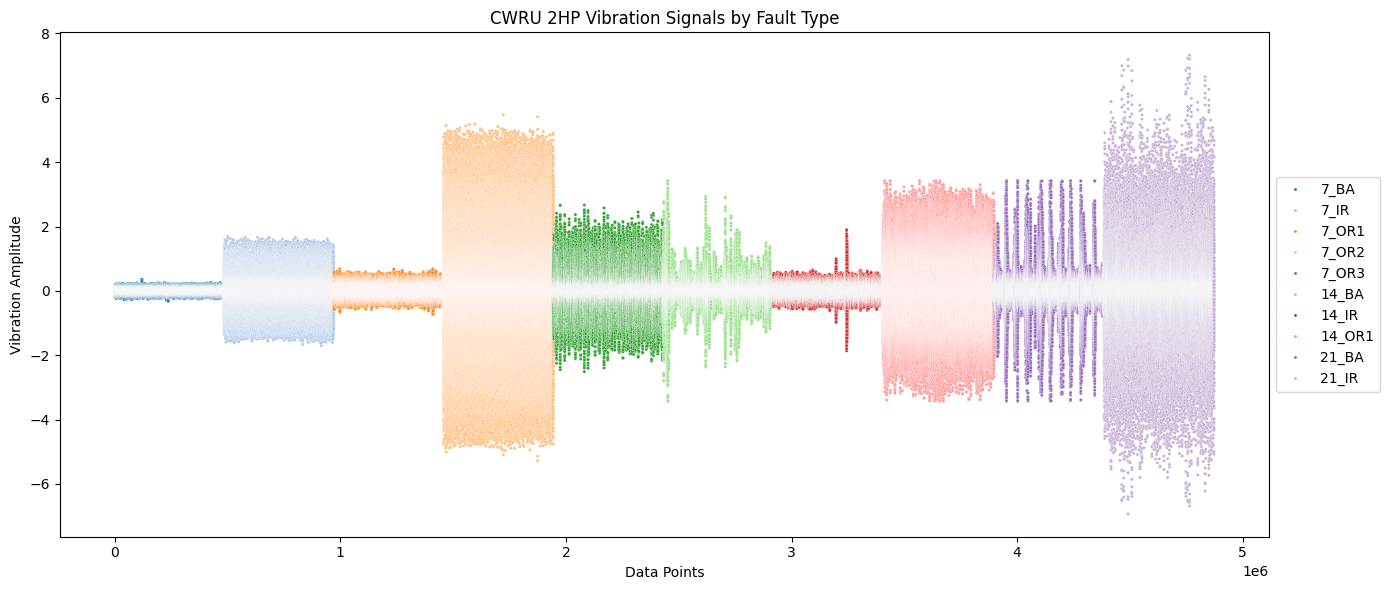

In [ ]:
# Example labels for 2HP
labels_2HP = [
    '7_BA',   # 0: Ball fault, 7 mils
    '7_IR',   # 1: Inner Race fault, 7 mils
    '7_OR1',  # 2: Outer Race fault @ 6 o’clock, 7 mils
    '7_OR2',  # 3: Outer Race fault @ 3 o’clock, 7 mils
    '7_OR3',  # 4: Outer Race fault @ 12 o’clock, 7 mils
    '14_BA',  # 5: Ball fault, 14 mils
    '14_IR',  # 6: Inner Race fault, 14 mils
    '14_OR1', # 7: Outer Race fault @ 6 o’clock, 14 mils
    '21_BA',  # 8: Ball fault, 21 mils
    '21_IR'   # 9: Inner Race fault, 21 mils
]
def make_dataframe(data_list, labels_list):
    all_data = []
    for signal, label in zip(data_list, labels_list):
        signal_flat = signal.flatten()
        df = pd.DataFrame({
            'Amplitude': signal_flat,
            'Label': [label] * len(signal_flat)
        })
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

df_2HP = make_dataframe(data_2HP, labels_2HP)
df_2HP['Index'] = df_2HP.index  # Continuous x-axis for plot


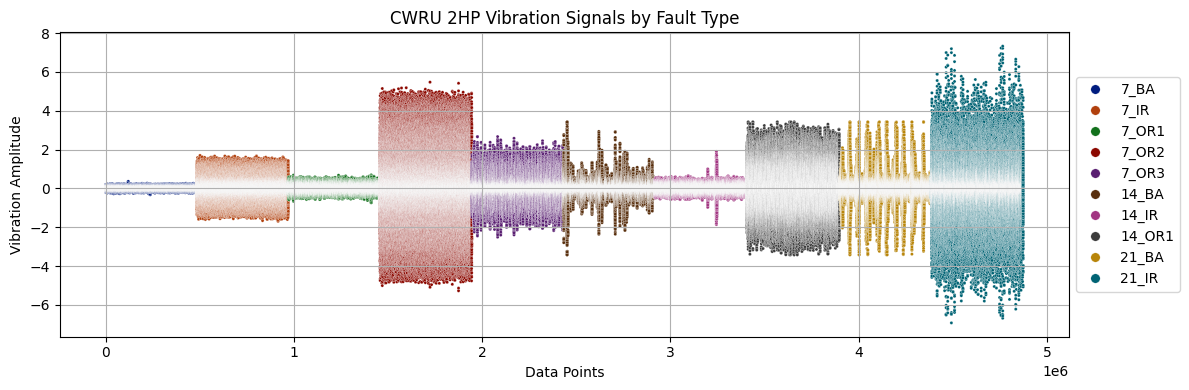

In [10]:
plt.figure(figsize=(12, 4))
sns.scatterplot(data=df_2HP, x='Index', y='Amplitude', hue='Label', s=5, palette='dark')
plt.title('CWRU 2HP Vibration Signals by Fault Type')
plt.xlabel('Data Points')
plt.ylabel('Vibration Amplitude')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, markerscale=3)
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import os

import numpy as np
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from keras import layers, models, initializers
from keras.callbacks import EarlyStopping
from scipy.io import loadmat

import random as rn

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, confusion_matrix, balanced_accuracy_score

import time
# Set seed for reproducibility
sd = 1
os.environ['PYTHONHASHSEED'] = str(sd)
np.random.seed(sd)
rn.seed(sd)
tf.random.set_seed(sd)


# Root directory that contains folders like K001, KA04, etc.
root_dir = './Paderborn_PreCase1_Data' 


## Define class labels  
#2016 Paper Case1 with Real Damages
data_structure = {
    0: ("Healthy", ["K001", "K002", "K003", "K004", "K005"]),
    1: ("OR_Damage", ["KA04", "KA15", "KA16", "KA22", "KA30"]),
    2: ("IR_Damage", ["KI04", "KI14", "KI16", "KI18", "KI21"]),
}

# data_structure = {
#     0: ("Healthy", ["K001"]),
#     1: ("OR_Damage", ["KA04"]),
#     2: ("IR_Damage", ["KI04"]),
# }



# Signal extractor function
def extract_signals_df(filepath, signal="all"):
    signals = {
        "vibration": 6,
        "current_1": 1,
        "current_2": 2,
    }

    mat = loadmat(filepath, struct_as_record=False, squeeze_me=True)
    field = next(k for k in mat if not k.startswith("__"))
    struct = mat[field]

    X_channels = struct.X
    Y_channels = struct.Y

    if signal == "vibration":
        v = Y_channels[signals["vibration"]].Data.flatten().reshape(-1, 1)
        return pd.DataFrame(v, columns=["vibration"])

    elif signal == "current":
        c1 = X_channels[signals["current_1"]].Data.flatten().reshape(-1, 1)
        c2 = Y_channels[signals["current_2"]].Data.flatten().reshape(-1, 1)
        return pd.DataFrame(np.concatenate([c1, c2], axis=1), columns=["current_1", "current_2"])

    elif signal == "all":
        v = Y_channels[signals["vibration"]].Data.flatten().reshape(-1, 1)
        c1 = X_channels[signals["current_1"]].Data.flatten().reshape(-1, 1)
        c2 = Y_channels[signals["current_2"]].Data.flatten().reshape(-1, 1)
        return pd.DataFrame(np.concatenate([v, c1, c2], axis=1),
                            columns=["vibration", "current_1", "current_2"])

    else:
        raise ValueError("Signal must be one of: 'vibration', 'current', or 'all'")
    
    # # # Process only the first several .mat files from each folder or define the number
all_data = []

for label, (category, folders) in data_structure.items():
    for folder in folders:
        folder_path = os.path.join(root_dir, folder)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} not found.")
            continue

        mat_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".mat")])
        
        # # Read the first two .mat files only 
        # for filename in mat_files[:2]:
            
        # Read the Second .mat files only 
        for filename in mat_files[1:2]:
            file_path = os.path.join(folder_path, filename)
            try:
                df = extract_signals_df(file_path, signal="all")
                df["label"] = label
                df["sample"] = filename.replace(".mat", "")
                all_data.append(df)
                print(f"Loaded: {file_path}")
            except Exception as e:
                print(f"Error reading {file_path}: {e}")           

# Concatenate all DataFrames
final_df = pd.concat(all_data, ignore_index=True)

# Preview
print("\nCombined data shape:", final_df.shape)
print(final_df.head())

# Select only vibration and label columns, then rename 'vibration' to 'signal'
df_signals = final_df[["vibration", "label"]].copy()
df_signals.rename(columns={"vibration": "signal"}, inplace=True)

# Preview the result
print("\nSignal DataFrame shape:", df_signals.shape)
print(df_signals.head())
# Group signals by label and convert to list of 1D numpy arrays
grouped_signals = [
    df_signals[df_signals['label'] == i]['signal'].values.astype(float)
    for i in sorted(df_signals['label'].unique())
]



Loaded: ./Paderborn_PreCase1_Data/K001/N09_M07_F10_K001_10.mat
Loaded: ./Paderborn_PreCase1_Data/K002/N09_M07_F10_K002_2.mat
Loaded: ./Paderborn_PreCase1_Data/K003/N09_M07_F10_K003_2.mat
Loaded: ./Paderborn_PreCase1_Data/K004/N09_M07_F10_K004_2.mat
Loaded: ./Paderborn_PreCase1_Data/K005/N09_M07_F10_K005_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA04/N09_M07_F10_KA04_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA15/N09_M07_F10_KA15_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA16/N09_M07_F10_KA16_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA22/N09_M07_F10_KA22_2.mat
Loaded: ./Paderborn_PreCase1_Data/KA30/N09_M07_F10_KA30_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI04/N09_M07_F10_KI04_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI14/N09_M07_F10_KI14_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI16/N09_M07_F10_KI16_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI18/N09_M07_F10_KI18_2.mat
Loaded: ./Paderborn_PreCase1_Data/KI21/N09_M07_F10_KI21_2.mat

Combined data shape: (3845043, 5)
   vibration  current_1  current_2

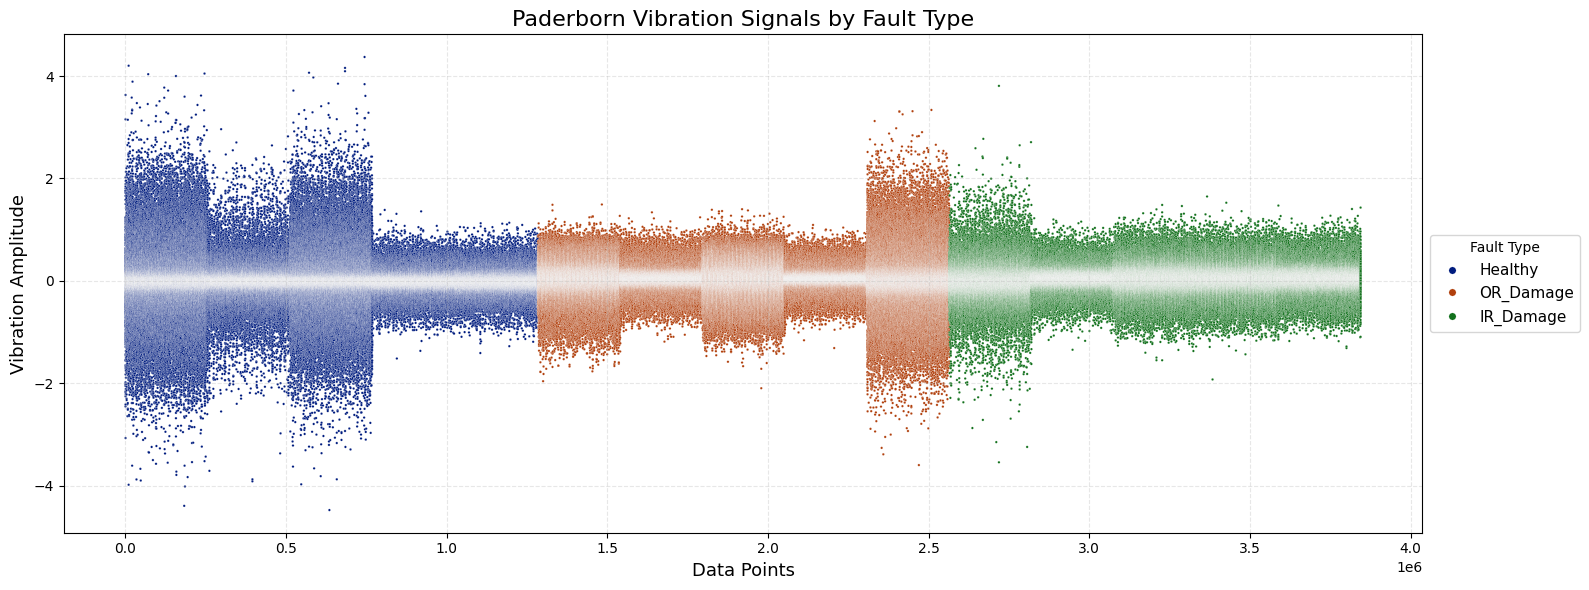

In [12]:
# Create label-to-name mapping
label_names = {0: "Healthy", 1: "OR_Damage", 2: "IR_Damage"}

# Prepare a long-form DataFrame for plotting
plot_data = []
offset = 0

for label, signal_array in zip(sorted(label_names.keys()), grouped_signals):
    n = len(signal_array)
    plot_data.append(pd.DataFrame({
        "Index": np.arange(offset, offset + n),
        "Amplitude": signal_array,
        "Label": label_names[label]
    }))
    offset += n

# Concatenate all
df_plot = pd.concat(plot_data, ignore_index=True)

# Plot
plt.figure(figsize=(16, 6))
sns.scatterplot(
    data=df_plot,
    x="Index",
    y="Amplitude",
    hue="Label",
    s=3,  # small dots
    palette="dark"  # darker color palette
)
plt.title("Paderborn Vibration Signals by Fault Type", fontsize=16)
plt.xlabel("Data Points", fontsize=13)
plt.ylabel("Vibration Amplitude", fontsize=13)

# Enlarge legend markers
plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title="Fault Type",
    fontsize=11,
    markerscale=3
)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


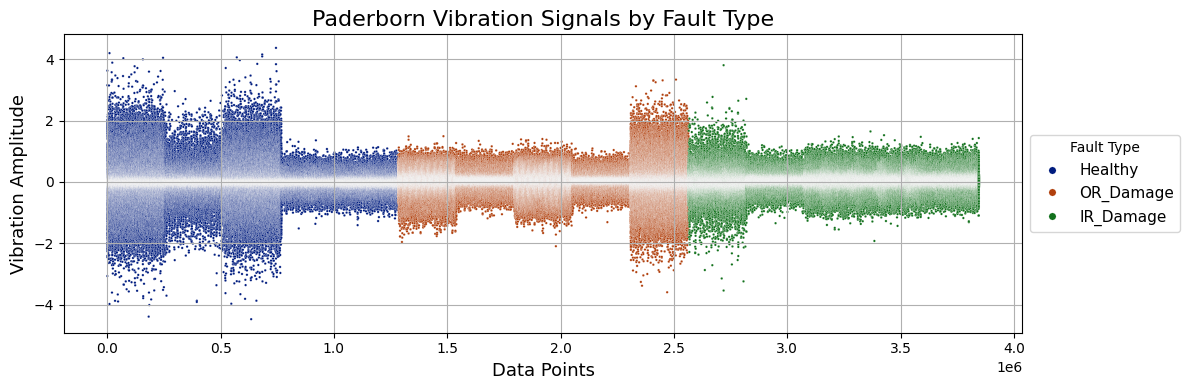

In [13]:
# Plot
plt.figure(figsize=(12, 4))
sns.scatterplot(
    data=df_plot,
    x="Index",
    y="Amplitude",
    hue="Label",
    s=3,  # small dots
    palette="dark"  # darker color palette
)
plt.title("Paderborn Vibration Signals by Fault Type", fontsize=16)
plt.xlabel("Data Points", fontsize=13)
plt.ylabel("Vibration Amplitude", fontsize=13)

# Enlarge legend markers
plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title="Fault Type",
    fontsize=11,
    markerscale=3
)
plt.grid(True)
plt.tight_layout()
plt.show()

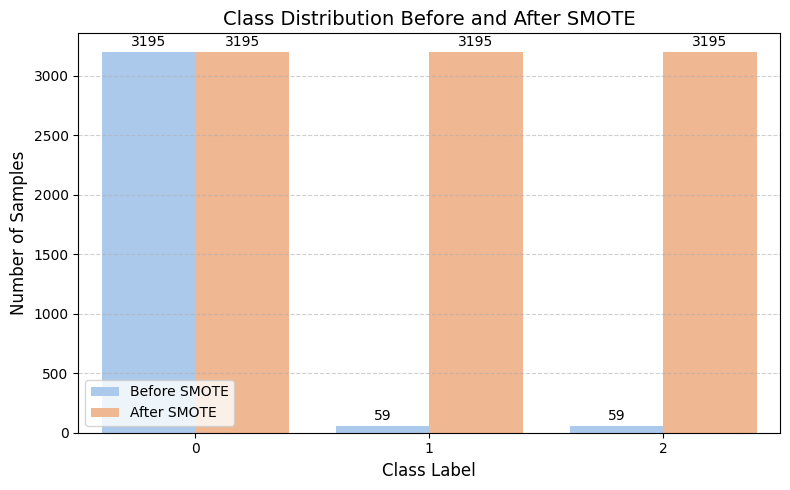

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
classes = [0, 1, 2]
before_counts = [3195, 59, 59]
after_counts = [3195, 3195, 3195]

# Combine into a DataFrame
df_dist = pd.DataFrame({
    'Class': classes * 2,
    'Count': before_counts + after_counts,
    'Stage': ['Before SMOTE'] * 3 + ['After SMOTE'] * 3
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df_dist, x='Class', y='Count', hue='Stage', palette='pastel')

# Formatting
plt.title("Class Distribution Before and After SMOTE", fontsize=14)
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(ticks=[0, 1, 2], labels=[0, 1, 2])
plt.tight_layout()

# Add value labels on top
for i in range(len(df_dist)):
    plt.text(
        x=i % 3 - 0.2 + (0.4 if df_dist['Stage'][i] == 'After SMOTE' else 0),
        y=df_dist['Count'][i] + 50,
        s=str(df_dist['Count'][i]),
        ha='center',
        fontsize=10
    )
plt.legend(loc = 'lower left')

plt.show()
